In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.svm import SVC

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader

import torchvision.models as models
import os
import cv2

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os

from PIL import Image

In [ ]:
# This cell was for testing - the actual
# ResNet18 implementation is below in cells 6-17
models = torchvision.models.resnet18(weights="IMAGENET1K_V1")

In [66]:
train_data = np.array([])
train_folder = os.path.join(os.getcwd(), "data", "train_features")
test_folder = os.path.join(os.getcwd(), "data", "test_features")


l = os.listdir(train_folder)
print(len(l))
t = os.listdir(test_folder)
print(len(t))

16489
4465


In [68]:
# print(l)

from typing import Any


dataframe = pd.read_csv(os.path.join(os.getcwd(), "data", "train_labels.csv"))
# dataframe_test = pd.read_csv(os.path.join(os.getcwd(), "data", "test_labels.csv"))

# dataframe.head()
# dataframe = dataframe[:10512]

id_list = dataframe["id"]


def to_hwc3(img: np.ndarray) -> np.ndarray:
    if img.ndim == 2:  # (H, W) -> (H, W, 3)
        return np.repeat(img[..., None], 3, axis=2)
    if img.ndim == 3:
        if img.shape[2] == 1:  # (H, W, 1) -> (H, W, 3)
            return np.repeat(img, 3, axis=2)
        if img.shape[2] >= 3:  # (H, W, 3) or (H, W, 4) -> keep first 3
            return img[..., :3]
    raise ValueError(f"Unexpected shape: {img.shape}")


# Load images into a list, then assign to dataframe
image_list = []
for i in id_list:
    # Load image and convert to numpy array immediately to avoid keeping file handles open
    with Image.open(os.path.join(train_folder, i + ".jpg")) as img:
        img_array = to_hwc3(np.array(img))
        image_list.append(img_array)

# Assign the list of numpy arrays to the dataframe
dataframe["image"] = image_list

print(f"Loaded {len(image_list)} images")
print(f"First image shape: {dataframe['image'][0].shape}")
print(f"Dataframe shape: {dataframe.shape}")

Loaded 16488 images
First image shape: (540, 960, 3)
Dataframe shape: (16488, 10)


In [69]:
dataframe.head(5)

,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent,image
0,ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[[140, 140, 140], [139, 139, 139], [139, 139,..."
1,ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"[[[131, 131, 131], [131, 131, 131], [132, 132,..."
2,ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[[158, 158, 158], [142, 142, 142], [139, 139,..."
3,ZJ000003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"[[[70, 115, 112], [72, 117, 114], [75, 115, 11..."
4,ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"[[[18, 37, 33], [92, 111, 107], [148, 167, 163..."


In [70]:
# ============================================
# PYTORCH RESNET18 IMPLEMENTATION
# ============================================

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define class names
class_names = [
    "antelope_duiker",
    "bird",
    "blank",
    "civet_genet",
    "hog",
    "leopard",
    "monkey_prosimian",
    "rodent",
]
num_classes = len(class_names)

Using device: cuda


In [71]:
# Define transforms
train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

print("Transforms defined!")

Transforms defined!


In [72]:
class AnimalDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

        # Extract labels (one-hot to class index)
        label_columns = class_names
        self.labels = dataframe[label_columns].values.argmax(axis=1)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get image (numpy array)
        image = self.dataframe.iloc[idx]["image"]
        label = self.labels[idx]

        # Convert numpy array to PIL Image for transforms
        image = Image.fromarray(image)
        # print("type shape", type(image))

        if self.transform:
            image = self.transform(image)

        return image, label

    def show_image(self, idx):
        image = self.dataframe.iloc[idx]["image"]
        plt.imshow(image)
        plt.axis("off")
        plt.show()

    def return_numpy_image(self, idx):
        return self.dataframe.iloc[idx]["image"]

    def return_transformed_image(self, idx):
        image = self.dataframe.iloc[idx]["image"]
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        return image

In [73]:
train_df, val_df = train_test_split(
    dataframe,
    test_size=0.25,
    random_state=42,
    stratify=dataframe[class_names].values.argmax(axis=1),
)

print(f"length: {len(train_df)}")
print(f"length: {len(val_df)}")

length: 12366
length: 4122


In [74]:
# Split data into train and validation sets
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    dataframe,
    test_size=0.2,
    random_state=42,
    stratify=dataframe[class_names].values.argmax(axis=1),
)

# Reset indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Create datasets
train_dataset = AnimalDataset(train_df, transform=train_transform)
val_dataset = AnimalDataset(val_df, transform=val_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=0
)

print(f"\nBatch size: {batch_size}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Training samples: 13190
Validation samples: 3298

Batch size: 32
Train batches: 413
Val batches: 104


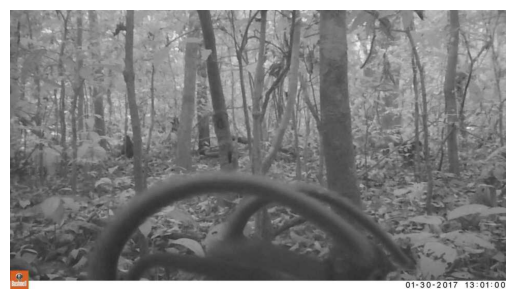

In [75]:
train_dataset.show_image(0)

In [76]:
train_dataset.return_numpy_image(0)

array([[[111, 111, 111],
        [112, 112, 112],
        [113, 113, 113],
        ...,
        [128, 128, 128],
        [137, 137, 137],
        [143, 143, 143]],

       [[109, 109, 109],
        [110, 110, 110],
        [112, 112, 112],
        ...,
        [125, 125, 125],
        [133, 133, 133],
        [137, 137, 137]],

       [[107, 107, 107],
        [109, 109, 109],
        [111, 111, 111],
        ...,
        [119, 119, 119],
        [125, 125, 125],
        [129, 129, 129]],

       ...,

       [[250, 157, 100],
        [207, 112,  56],
        [192,  96,  38],
        ...,
        [253, 253, 253],
        [255, 255, 255],
        [243, 243, 243]],

       [[251, 156,  98],
        [208, 112,  52],
        [195,  95,  35],
        ...,
        [252, 252, 252],
        [251, 251, 251],
        [255, 255, 255]],

       [[251, 157,  96],
        [208, 112,  51],
        [197,  95,  33],
        ...,
        [245, 245, 245],
        [244, 244, 244],
        [255, 255, 255]]

In [77]:
train_df.head(5)

,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent,image
0,ZJ008378,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"[[[111, 111, 111], [112, 112, 112], [113, 113,..."
1,ZJ010739,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"[[[54, 54, 54], [55, 55, 55], [57, 57, 57], [5..."
2,ZJ012427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[[[52, 88, 84], [49, 85, 81], [48, 80, 77], [4..."
3,ZJ008859,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"[[[54, 54, 54], [54, 54, 54], [54, 54, 54], [5..."
4,ZJ012385,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"[[[72, 72, 72], [72, 72, 72], [71, 71, 71], [7..."


In [78]:
col = train_df.columns
print(col)

Index(['id', 'antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog',
       'leopard', 'monkey_prosimian', 'rodent', 'image'],
      dtype='object')


In [79]:
for i in range(1, 8):

    ones_in_colA = train_df[col[i]].value_counts().get(1, 0)
    print(f"Number of '1's in {col[i]}: {ones_in_colA}")

Number of '1's in antelope_duiker: 1979
Number of '1's in bird: 1313
Number of '1's in blank: 1770
Number of '1's in civet_genet: 1938
Number of '1's in hog: 783
Number of '1's in leopard: 1803
Number of '1's in monkey_prosimian: 1994


In [80]:
val_df.head(10)

,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent,image
0,ZJ000889,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"[[[38, 38, 38], [38, 38, 38], [38, 38, 38], [3..."
1,ZJ010803,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[[[52, 52, 52], [52, 52, 52], [53, 53, 53], [5..."
2,ZJ011344,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[[[253, 253, 253], [250, 250, 250], [248, 248,..."
3,ZJ003645,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[[[108, 150, 140], [107, 149, 139], [105, 147,..."
4,ZJ011329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[[[52, 52, 52], [54, 54, 54], [56, 56, 56], [5..."
5,ZJ004967,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"[[[99, 99, 99], [93, 93, 93], [89, 89, 89], [9..."
6,ZJ005400,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"[[[30, 32, 18], [15, 17, 3], [24, 26, 12], [8,..."
7,ZJ010858,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[[80, 112, 99], [80, 112, 99], [81, 113, 100]..."
8,ZJ002699,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[[[89, 89, 89], [90, 90, 90], [91, 91, 91], [9..."
9,ZJ003962,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"[[[52, 52, 52], [52, 52, 52], [53, 53, 53], [5..."


In [81]:
# Load ResNet18 model with pretrained weights
from torchvision.models import resnet18, ResNet18_Weights

model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Modify the final layer for our number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

# Move model to device
model = model.to(device)

print(f"Model created with {num_classes} output classes")
print(f"Final layer: {model.fc}")

Model created with 8 output classes
Final layer: Linear(in_features=512, out_features=8, bias=True)


In [82]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    patience=2,
    factor=0.5,
)

print("Loss function: CrossEntropyLoss")
print("Optimizer: Adam (lr=0.001)")
print("Scheduler: ReduceLROnPlateau")

Loss function: CrossEntropyLoss
Optimizer: Adam (lr=0.001)
Scheduler: ReduceLROnPlateau


In [83]:
# Validation function
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels


print("Validation function defined!")

Validation function defined!


In [84]:
# Custom Dataset Class
from torch.utils.data import Dataset, DataLoader


def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 1

    for images, labels in dataloader:
        # print(images)
        # print(labels)
        images, labels = images.to(device), labels.to(device)

        # # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
    return epoch_loss, epoch_acc


# Training loop
num_epochs = 10
best_val_acc = 0.0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

print("Starting training...")
print("=" * 60)


for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 60)

    # print("train_loader", train_loader)
    # print("model", model)
    # print("criterion", criterion)
    # print("optimizer", optimizer)
    # print("device", device)

    # Train

    # train_loader.return_transformed_image(0)

    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device
    )

    val_loss, val_acc, val_preds, val_labels = validate_epoch(
        model, val_loader, criterion, device
    )

    # Update scheduler
    scheduler.step(val_loss)

    # Save history
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    # Print stats
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_resnet18_model.pth")
        print(f"✓ Best model saved! (Val Acc: {val_acc:.4f})")

print("\n" + "=" * 60)
print(f"Training completed! Best Val Acc: {best_val_acc:.4f}")

Starting training...

Epoch 1/10
------------------------------------------------------------
Train Loss: 1.5353, Train Acc: 0.4123
Train Loss: 1.5353 | Train Acc: 0.4123
Val Loss:   1.3884 | Val Acc:   0.4682
✓ Best model saved! (Val Acc: 0.4682)

Epoch 2/10
------------------------------------------------------------
Train Loss: 1.2845, Train Acc: 0.5160
Train Loss: 1.2845 | Train Acc: 0.5160
Val Loss:   1.1333 | Val Acc:   0.5867
✓ Best model saved! (Val Acc: 0.5867)

Epoch 3/10
------------------------------------------------------------
Train Loss: 1.0884, Train Acc: 0.6067
Train Loss: 1.0884 | Train Acc: 0.6067
Val Loss:   1.2337 | Val Acc:   0.5761

Epoch 4/10
------------------------------------------------------------
Train Loss: 0.9371, Train Acc: 0.6583
Train Loss: 0.9371 | Train Acc: 0.6583
Val Loss:   0.8511 | Val Acc:   0.6992
✓ Best model saved! (Val Acc: 0.6992)

Epoch 5/10
------------------------------------------------------------
Train Loss: 0.8206, Train Acc: 0.701

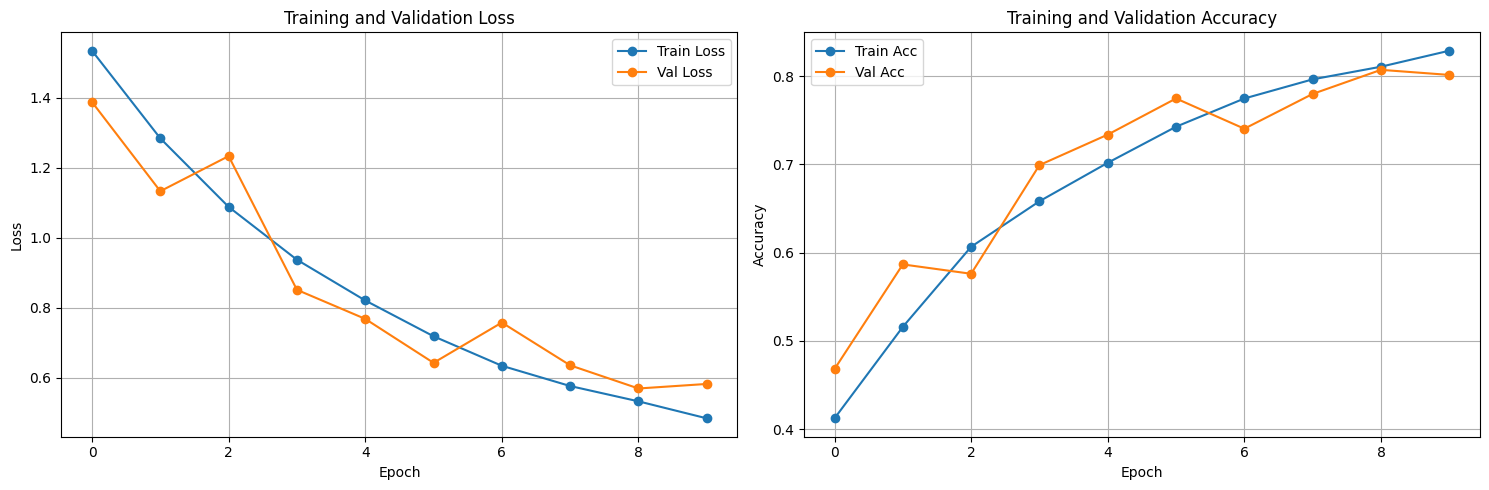

In [85]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history["train_loss"], label="Train Loss", marker="o")
axes[0].plot(history["val_loss"], label="Val Loss", marker="o")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training and Validation Loss")
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(history["train_acc"], label="Train Acc", marker="o")
axes[1].plot(history["val_acc"], label="Val Acc", marker="o")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Training and Validation Accuracy")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

Final Evaluation on Validation Set

Best Model Performance:
Val Loss: 0.5687
Val Accuracy: 0.8072


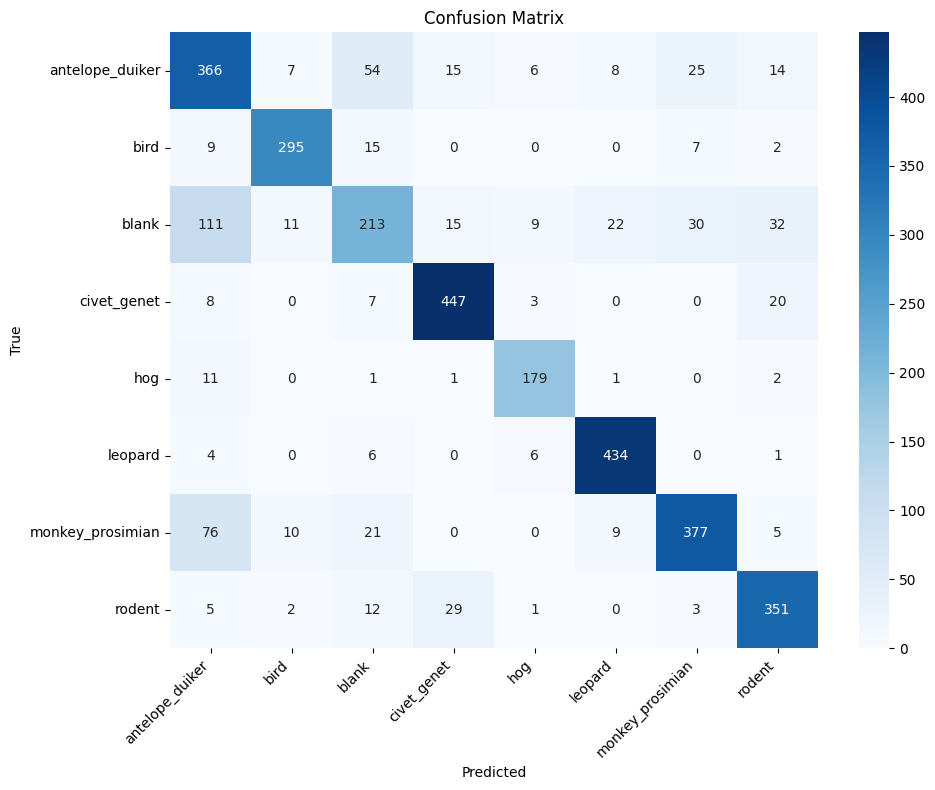


Classification Report:
                  precision    recall  f1-score   support

 antelope_duiker     0.6203    0.7394    0.6747       495
            bird     0.9077    0.8994    0.9035       328
           blank     0.6474    0.4808    0.5518       443
     civet_genet     0.8817    0.9216    0.9012       485
             hog     0.8775    0.9179    0.8972       195
         leopard     0.9156    0.9623    0.9384       451
monkey_prosimian     0.8529    0.7570    0.8021       498
          rodent     0.8220    0.8710    0.8458       403

        accuracy                         0.8072      3298
       macro avg     0.8156    0.8187    0.8143      3298
    weighted avg     0.8063    0.8072    0.8036      3298



In [86]:
# Final evaluation on validation set
print("Final Evaluation on Validation Set")
print("=" * 60)

# Load best model
model.load_state_dict(torch.load("best_resnet18_model.pth"))

# Evaluate
val_loss, val_acc, val_preds, val_labels = validate_epoch(
    model, val_loader, criterion, device
)

print(f"\nBest Model Performance:")
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_acc:.4f}")

# Confusion Matrix
from sklearn.metrics import classification_report

cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(val_labels, val_preds, target_names=class_names, digits=4))

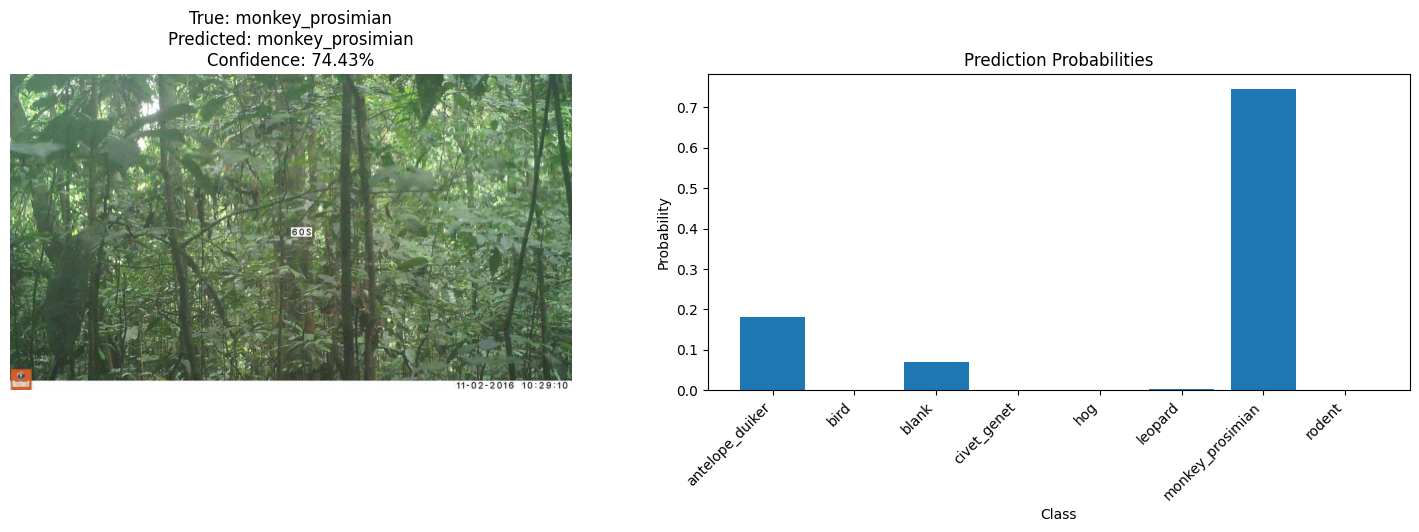

Image ID: ZJ016378
True Label: monkey_prosimian
Predicted: monkey_prosimian
Confidence: 74.43%


: 

In [ ]:
# Function to predict on a single image
def predict_image(model, image_path, transform, device, class_names):
    model.eval()

    # Load and transform image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

    predicted_class = class_names[predicted.item()]
    confidence_score = confidence.item()

    return predicted_class, confidence_score, probabilities.cpu().numpy()[0]


# Example: Predict on a random validation image
import random

random_idx = random.randint(0, len(val_df) - 1)
test_id = val_df.iloc[random_idx]["id"]
test_image_path = os.path.join(train_folder, test_id + ".jpg")
true_label_idx = val_df[class_names].iloc[random_idx].values.argmax()
true_label = class_names[true_label_idx]

predicted_class, confidence, probs = predict_image(
    model, test_image_path, val_transform, device, class_names
)

# Display results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Show image
img = Image.open(test_image_path)
axes[0].imshow(img)
axes[0].axis("off")
axes[0].set_title(
    f"True: {true_label}\nPredicted: {predicted_class}\nConfidence: {confidence:.2%}"
)

# Show probability distribution
axes[1].bar(class_names, probs)
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Probability")
axes[1].set_title("Prediction Probabilities")
axes[1].tick_params(axis="x", rotation=45)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print(f"Image ID: {test_id}")
print(f"True Label: {true_label}")
print(f"Predicted: {predicted_class}")
print(f"Confidence: {confidence:.2%}")

# 📊 ResNet18 Model Summary

## Model Architecture

- **Base Model**: ResNet18 with ImageNet pretrained weights
- **Output Classes**: 8 (antelope_duiker, bird, blank, civet_genet, hog, leopard, monkey_prosimian, rodent)
- **Input Size**: 224x224 RGB images

## Training Configuration

- **Optimizer**: Adam (lr=0.001)
- **Loss Function**: CrossEntropyLoss
- **Batch Size**: 32
- **Epochs**: 10
- **Data Split**: 80% train, 20% validation
- **Scheduler**: ReduceLROnPlateau

## Data Augmentation

- Random horizontal flip
- Random rotation (±10°)
- Color jitter (brightness, contrast, saturation)
- Normalization with ImageNet statistics

## Key Features

✅ GPU acceleration (if available)  
✅ Learning rate scheduling  
✅ Best model checkpointing  
✅ Training history visualization  
✅ Confusion matrix & classification report  
✅ Single image prediction with confidence scores


# 🚀 Quick Start Guide

## To run the complete pipeline:

1. **Run Cells 0-5**: Import libraries and load data
2. **Run Cells 6-13**: Setup model, datasets, and training/validation functions
3. **Run Cell 14**: Train the model (this will take some time!)
4. **Run Cell 15**: Visualize training history
5. **Run Cell 16**: View confusion matrix and classification report
6. **Run Cell 17**: Test prediction on a random image

## To make predictions on new images:

```python
# Example usage:
image_path = "path/to/your/image.jpg"
predicted_class, confidence, probs = predict_image(
    model, image_path, val_transform, device, class_names
)
print(f"Predicted: {predicted_class} (Confidence: {confidence:.2%})")
```

## Model Saving/Loading:

```python
# Save model
torch.save(model.state_dict(), 'my_model.pth')

# Load model
model.load_state_dict(torch.load('my_model.pth'))
```
